In [2]:
import qutip
import numpy as np
from trajectree.fock_optics.outputs import print_quantum_state
from trajectree.fock_optics.utils import create_vacuum_state, read_quantum_state
from trajectree.fock_optics.light_sources import light_source, create_TMSV_OP_Dense
from scipy.sparse import kron
from scipy import sparse as sp
from numpy import sqrt, exp, pi
from math import factorial
from matplotlib import pyplot as plt 

/home/asingal/home/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/asingal/home/.venv/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


This file is comparing the light source in trajectree with the light source from SeQUeNCe used to perform the FiO experiment. 

In [3]:
# Recreating the FiO statevector here. 

def _find_mat_exp(mat):
        ans = sp.eye(mat.shape[0])
        intermediate = 1
        # print("finding matrix exp")
        for i in range(1, 50+1):
            # print("done one iteration")
            intermediate *= mat/i
            # intermediate.data = np.round(intermediate.data, 10)
            # print("num_elements:", len(intermediate.data))
            intermediate.eliminate_zeros()


            ans += intermediate
            # temp.data = intermediate / factorial(i)
        # print("done finding matrix exp")
        return ans



def power(matrix, power):
    if power:
        return matrix**power
    return sp.eye(matrix.shape[0])


def _generate_tmsv_state(N=3, mean_photon_num=0.1, dm = False):
    """Method to generate two-mode squeezed vacuum state of two output photonic modes
        Problem with this method: When you add up the H and V TMSV components, you are 
        creating an incoherent mixture. This is wrong since an entanglement is a coherent 
        mixture of these components. So, you'll have to use the PBS unitary to perform the 
        combination of H and V components coherently 
    Returns:
        array: generated state.
    """

    I = sp.eye(N)
    a = sp.csr_matrix(qutip.destroy(N).full())
    a_V = kron(a, I)
    adag_V = a_V.conjugate().transpose() 
    a_H = kron(I, a)
    adag_H = a_H.conjugate().transpose() 

    I = sp.eye(N**2)
    
    theta_H = np.pi/2

    # print("types:", type(a_V), type(a_V), type(adag_V), type(adag_V), type(I))

    a_H_Signal = kron(a_H, I, "csr")
    adag_H_Signal = kron(adag_H, I, "csr")
    a_H_Idler = kron(I, a_H, "csr")
    adag_H_Idler = kron(I, adag_H, "csr")
    II = kron(I,I, "csr")

    hamiltonian_H_Signal = theta_H * ( kron(II, a_H_Signal, "csr")@kron(adag_H_Signal,II, "csr") - kron(a_H_Signal, II, "csr")@kron(II, adag_H_Signal, "csr") )
    # print("done1")
    hamiltonian_H_Idler = theta_H * ( kron(II, a_H_Idler, "csr")@kron(adag_H_Idler,II, "csr") - kron(a_H_Idler, II, "csr")@kron(II, adag_H_Idler, "csr") )

    U_v_Signal = _find_mat_exp(hamiltonian_H_Signal)
    U_v_Signal.data = np.round(U_v_Signal.data, 12)
    U_v_Signal.eliminate_zeros()

    U_v_Idler = _find_mat_exp(hamiltonian_H_Idler)
    U_v_Idler.data = np.round(U_v_Idler.data, 12)
    U_v_Idler.eliminate_zeros()
        
    BS_U = U_v_Signal @ U_v_Idler

    # Now, we create the 2 TMSV state operators interacting at the Beamsplitter. 

    mean_num = mean_photon_num
    # print("mean_num", mean_num)
    truncation = N-1
    dim = N**2

    vacuum = sp.csr_matrix((dim, 1))
    vacuum[0,0] = 1        

    def generate_amp_list(mean_num):
        amp_list = [(sqrt(mean_num / (mean_num + 1)) ** m) / sqrt(mean_num + 1) for m in range(truncation)]
        amp_square_list = [amp ** 2 for amp in amp_list]
        amp_list.append(sqrt(1 - sum(amp_square_list)))
        return amp_list

    ampH = generate_amp_list(mean_num)
    ampV = generate_amp_list(mean_num)

    op_H = 0
    op_V = 0
    for i in range(truncation+1):
        # TMSV is a 2 mode state (independent spatial modes). Hence, we take the tensor product of the two mode operators
        new_op_H = ampH[i] * ( power(sp.kron(adag_H, adag_H), i) ) / factorial(i)
        new_op_V = ampV[i] * ( power(sp.kron(adag_V, adag_V), i) ) / factorial(i)
        op_H += new_op_H
        op_V += new_op_V
    
    TMSV_H_state = op_H @ sp.kron(vacuum, vacuum)
    TMSV_V_state = op_V @ sp.kron(vacuum, vacuum)

    total_state = kron(TMSV_H_state, TMSV_V_state)

    entangled_state = BS_U @ total_state

    entangled_state.data = np.round(entangled_state.data, 10)

    state_indices, _ = entangled_state.nonzero()

    entangled_state.eliminate_zeros()

    print_quantum_state(N, entangled_state, num_states = 4, return_string = False)

    if not dm:
        return entangled_state

    entangled_state = 1/np.sqrt((entangled_state.conjugate().transpose() @ entangled_state)[0,0]) * entangled_state

    entangled_state = entangled_state @ entangled_state.conjugate().transpose()
    reduced_state = entangled_state[:dim**2, :dim**2]    
    return reduced_state


In [4]:
N = 3
mean_photon_num = (0.15)
state = _generate_tmsv_state(N = N, mean_photon_num = mean_photon_num)
state

Corresponding Basis terms:
0H0V_D 0H0V_C 0H0V_B 0H0V_A - 0 - [0.86956522+0.j]
0H0V_D 0H0V_C 1H0V_B 1H0V_A - 10 - [0.31405005+0.j]
0H0V_D 0H0V_C 2H0V_B 2H0V_A - 20 - [0.12163106+0.j]
0H0V_D 0H0V_C 0H1V_B 0H1V_A - 30 - [0.31405005+0.j]
0H0V_D 0H0V_C 1H1V_B 1H1V_A - 40 - [0.11342155+0.j]
0H0V_D 0H0V_C 2H1V_B 2H1V_A - 50 - [0.04392798+0.j]
0H0V_D 0H0V_C 0H2V_B 0H2V_A - 60 - [0.12163106+0.j]
0H0V_D 0H0V_C 1H2V_B 1H2V_A - 70 - [0.04392798+0.j]
0H0V_D 0H0V_C 2H2V_B 2H2V_A - 80 - [0.01701323+0.j]


/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


<Compressed Sparse Row sparse matrix of dtype 'complex128'
	with 9 stored elements and shape (6561, 1)>

In [5]:
vacuum = create_vacuum_state(num_modes=8, N=N)

psi, TMSV_state = light_source(vacuum, N, mean_photon_num, 8, 1e-12, compress=True, contract=True)

read_quantum_state(psi, N, num_states = 4)

Corresponding Basis terms:
0H0V_D 0H0V_C 0H0V_B 0H0V_A - 0 - [0.86981524+0.j]
0H0V_D 0H0V_C 1H0V_B 1H0V_A - 10 - [-0.31216896+0.j]
0H0V_D 0H0V_C 2H0V_B 2H0V_A - 20 - [0.12564724+0.j]
0H0V_D 0H0V_C 0H1V_B 0H1V_A - 30 - [-0.31216896+0.j]
0H0V_D 0H0V_C 1H1V_B 1H1V_A - 40 - [0.11203467+0.j]
0H0V_D 0H0V_C 2H1V_B 2H1V_A - 50 - [-0.04509368+0.j]
0H0V_D 0H0V_C 0H2V_B 0H2V_A - 60 - [0.12564724+0.j]
0H0V_D 0H0V_C 1H2V_B 1H2V_A - 70 - [-0.04509368+0.j]
0H0V_D 0H0V_C 2H2V_B 2H2V_A - 80 - [0.01815009+0.j]


In [8]:
N = 4
mean_photon_num = 0.5

vacuum_dense = np.zeros((N**2,1))
vacuum_dense[0,0] = 1
TMSV_state = create_TMSV_OP_Dense(N, mean_photon_num) @ vacuum_dense

state_probabilities = []

for i in range(N):
    reference_state = np.zeros((N,1))
    reference_state[i,0] = 1
    reference_state = np.kron(reference_state, reference_state)

    # print(reference_state.shape, TMSV_state.shape)

    state_probabilities.append(np.abs(reference_state.T @ TMSV_state)[0,0])

0.6584789484624084


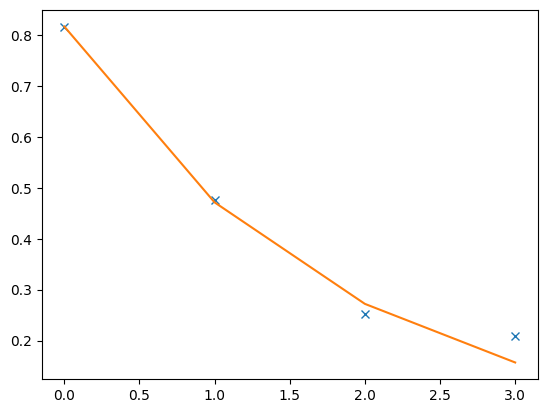

In [9]:
plt.plot(state_probabilities, 'x')

chi = np.asinh(np.sqrt(mean_photon_num))
print(chi)
TMSV_dist = [np.tanh(chi)**n / np.cosh(chi) for n in range(N)]

plt.plot(TMSV_dist)